# DeepOF unsupervised pipeline: exploring the behavioral space

In [1]:
import os
os.chdir("../../..")
import deepof.data

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pickle
import numpy as np
with open("../train_models/deepof_unsupervised_VQVAE_encodings_input=coords_k=100_latdim=8_kmeans_loss=0.0_run=1.pkl", "rb") as handle:
    vqvae_solution = pickle.load(handle)

In [4]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from deepof.post_hoc import get_transitions
from hmmlearn.hmm import GaussianHMM
from tqdm import tqdm_notebook as tqdm


def merge_and_smooth_clusters(
    n_clusters, centroids, embedding, concat_embedding, cluster_assignments
):
    """Merges the current clusters using a hierarchical agglomerative approach, and smoothens using a Gaussian HMM.

    Args:
        n_clusters (int): number of clusters to report.
        centroids (np.ndarray): precomputed means per cluster.
        embedding (tabdict): original deepof.TableDict object containing unsupervised embeddings.
        concat_embedding (np.ndarray): concatenated list of embeddings per animal in the dataset.
        cluster_assignments (tabdict): original deepof.TableDict object containing cluster assignments.

    Returns:
        new_soft_assignments (np.ndarray): concatenated postprocessed assignments for all animals in the dataset.
    """

    # Merge clusters ussing a hierarchical agglomerative approach
    new_hard_assignments = AgglomerativeClustering(
        n_clusters=n_clusters, compute_distances=True
    ).fit_predict(centroids)
    cluster_predictor = LinearDiscriminantAnalysis().fit(
        centroids, new_hard_assignments
    )
    centroids = cluster_predictor.means_
    new_soft_assignments = cluster_predictor.predict_proba(concat_embedding)

    # Rebuild the soft assignments dictionary per experimental animal
    new_soft_assignments = np.split(
        new_soft_assignments,
        np.cumsum([i.shape[0] for i in embedding.values()]),
    )
    new_soft_assignments = {
        key: val for key, val in zip(cluster_assignments.keys(), new_soft_assignments)
    }

    # Smooth assignments across time using a Gaussian HMM on the embeddings, with priors based on the clustering results
    for key, val in tqdm(new_soft_assignments.items()):

        hmm = GaussianHMM(
            startprob_prior=np.unique(val.argmax(axis=1), return_counts=True)[1],
            transmat_prior=get_transitions(val.argmax(axis=1), n_states=n_clusters) + 10,
            means_prior=centroids,
            n_components=n_clusters,
            covariance_type="diag",
            n_iter=100,
            tol=0.0001,
        )
        
        hmm.fit(embedding[key].numpy())
        new_soft_assignments[key] = hmm.predict_proba(embedding[key].numpy())

    return new_soft_assignments


def cluster_postprocessing(embedding, cluster_assignments, n_clusters="auto"):
    """Merges clusters using a hierarchical approach.

    Args:
        embedding (list): list of embeddings per animal in the dataset.
        cluster_assignments (list): list of cluster assignments per animal in the dataset.
        n_clusters (int): number of clusters to report.

    Returns:
        new_soft_assignments (list): list of new (merged) cluster assignments.

    """
    # Concatenate embeddings and cluster assignments in to unique np.ndarray objects
    concat_embedding = np.concatenate([tensor.numpy() for tensor in embedding.values()])
    hard_assignments = np.concatenate(
        [tensor.numpy().argmax(axis=1) for tensor in cluster_assignments.values()]
    )

    assert concat_embedding.shape[0] == hard_assignments.shape[0]

    # Get cluster centroids from the concatenated embeddings
    centroids = []
    for cluster in range(np.max(hard_assignments)):
        centroid = concat_embedding[hard_assignments == cluster]
        if len(centroid) == 0:
            continue
        centroid = np.mean(centroid, axis=0)
        centroids.append(centroid)

    centroids = np.stack(centroids)

    # Merge centroids using a hierarchical approach with the given resolution, and soft-assign instances to clusters
    if isinstance(n_clusters, int):
        new_soft_assignments = merge_and_smooth_clusters(
            n_clusters, centroids, embedding, concat_embedding, cluster_assignments
        )

    else:
        raise NotImplementedError

    return new_soft_assignments

In [ ]:
# from hmmlearn.hmm import GaussianHMM

# new_ass = cluster_postprocessing(
#     vqvae_solution[0], 
#     vqvae_solution[1],
#     n_clusters=12
# )
# hcc = new_ass['20191203_Day1_SI_JB08_Test_54'].argmax(axis=1)

In [ ]:
# import umap

# # Cluster on the original embedding space
# new_emb = umap.UMAP(n_components=2, n_neighbors=75).fit_transform(vqvae_solution[0]['20191203_Day1_SI_JB08_Test_54'])

# sns.scatterplot(x=new_emb[:, 0], y=new_emb[:, 1], hue=hcc, palette="tab20")

# plt.show()

In [ ]:
# # How prevalent are these clusters?
# from collections import Counter
# print(Counter(hcc))

# new_ass = hcc

In [ ]:
# # How often does the model change clusters?
# from collections import defaultdict

# lengths = defaultdict(list)
# cur = 0
# for i in range(1, len(new_ass)):
#     if new_ass[i-1] == new_ass[i]:
#         cur += 1
#     else:
#         lengths[new_ass[i-1]].append(cur)
#         cur = 1

# {key:np.mean(val) for key, val in lengths.items()}

In [ ]:
# import pandas as pd

# # Duration histograms per cluster
# lengths_df = pd.DataFrame([lengths]).melt().explode("value").astype(int)
# sns.violinplot(data=lengths_df, x="variable", y="value")

# plt.axhline(25, linestyle="--", color="black")
        
# plt.show()

In [5]:
my_deepof_project = deepof.data.load("../../Desktop/deepOF_CSDS_tutorial_dataset/deepof_tutorial_saved_project_1672667128.pkl")

In [6]:
# Check scales across animals. Can we detect to which animal a given time series belongs to?
# Once happy with a solution, check that all animals show comparable cluster interpretations.

# Add preprocessing options to include multiple animals, concatenated and together in a graph

tt = my_deepof_project.get_coords(center="Center", align="Spine_1")
# ss = my_deepof_project.get_coords(speed=1)

# tt = cc.merge(ss)

tt = tt.preprocess(
    window_size=25,
    window_step=1,
    test_videos=1,
    scale="standard",
    handle_ids="split", # "concat" uses bps from != animals as features, "split"
)

tt = (tt[0][:25000], tt[1][:25000], tt[2][:25000], tt[3][:25000])

In [7]:
from deepof.utils import connect_mouse_topview
import networkx as nx

pp = my_deepof_project.get_graph_dataset(
  #  animal_id="B",
    center="Center",
    align="Spine_1",
    preprocess=True,
    scale="standard"
)

G = connect_mouse_topview(animal_ids=["B", "W"], exclude_bodyparts=["Tail_1", "Tail_2", "Tail_tip"])
adj = nx.adjacency_matrix(G).todense()
pp = (pp[0][:25000], pp[1][:25000], pp[2][:25000], pp[3][:25000], pp[4][:25000], pp[5][:25000])

/var/folders/wf/msmt6cvx5xl9t0p2qjd1tn65jtl6l8/T/ipykernel_20714/2099027985.py:13: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).todense()


In [8]:
pp[0].shape

(25000, 25, 66)

In [9]:
pp[1].shape

(25000, 25, 26)

In [14]:
%%time
cons = my_deepof_project.deep_unsupervised_embedding(
    pp,
    adjacency_matrix=adj,
    embedding_model="Contrastive",
    epochs=1,
    encoder_type="transformer",
    n_components=15,
    latent_dim=8,
    kl_warmup=10,
    kl_annealing_mode="linear",
    batch_size=128,
    kmeans_loss=0.0,
    reg_cat_clusters=0.0,
)

2023-01-03 17:37:06.686322: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2023-01-03 17:37:06.686334: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2023-01-03 17:37:06.686398: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2023-01-03 17:37:07.534215: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


  1/195 [..............................] - ETA: 25:12 - total_loss: 0.3126 - pos_similarity: 0.1112 - neg_similarity: 0.0218

2023-01-03 17:37:15.456720: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2023-01-03 17:37:15.456735: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


  2/195 [..............................] - ETA: 12:48 - total_loss: 0.2649 - pos_similarity: 0.1049 - neg_similarity: 0.0213

2023-01-03 17:37:19.386643: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-01-03 17:37:19.396070: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2023-01-03 17:37:19.404628: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /Users/lucas_miranda/PycharmProjects/deepof/unsupervised_trained_models/fit/deepof_unsupervised_Contrastive_transformer_encodings_input_type=coords_kmeans_loss=0.0_encoding=8_k=15_20230103-173706/plugins/profile/2023_01_03_17_37_19

2023-01-03 17:37:19.413325: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /Users/lucas_miranda/PycharmProjects/deepof/unsupervised_trained_models/fit/deepof_unsupervised_Contrastive_transformer_encodings_input_type=coords_kmeans_loss=0.0_encoding=8_k=15_20230103-173706/plugins/profile/2023_01_03_17_37_19/MC-C9791E.local.trace.json.gz
2023-01-03 17:37:19.431993: I tensor

195/195 [==============================] - ETA: 0s - total_loss: 0.1238 - pos_similarity: 0.2443 - neg_similarity: 0.0136

2023-01-03 17:38:49.800228: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


195/195 [==============================] - 102s 488ms/step - total_loss: 0.1238 - pos_similarity: 0.2443 - neg_similarity: 0.0136 - lr: 0.0010
CPU times: user 9min, sys: 2min 14s, total: 11min 15s
Wall time: 1min 43s


In [25]:
import pandas as pd
import os

files = [i for i in os.listdir("../../Desktop/deepOF_datasets/Tagged_videos/Data_for_deepof_OF/JB08_files_OF/Tables/")]

for f in files:
    cur = pd.read_hdf("../../Desktop/deepOF_datasets/Tagged_videos/Data_for_deepof_OF/JB08_files_OF/Tables/" + f)
    
    cur.to_csv("../../Desktop/deepOF_datasets/Tagged_videos/Data_for_deepof_OF/JB08_files_OF/Tables/" + f[:-2] + "csv")

In [122]:
emb = cons.encoder([pp[0][:25000], pp[1][:25000]])
cls = cons.quantizer([pp[0][:25000], pp[1][:25000]])

In [123]:
import umap
umap = umap.UMAP(
    n_components=2, 
    n_neighbors=250,
    min_dist=1.0,
).fit_transform(emb.numpy())
# umap = emb.numpy()

In [124]:
from collections import Counter

Counter(cls.numpy().argmax(axis=1))

Counter({7: 813, 1: 16252, 5: 3567, 6: 2284, 2: 650, 0: 1407, 4: 27})

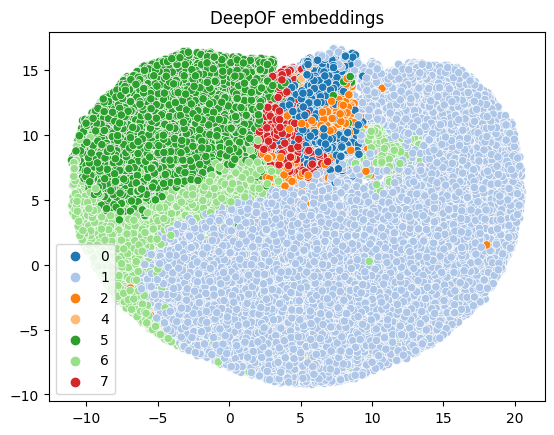

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt

#tt = GaussianMixture(n_components=5, covariance_type="diag", reg_covar=1e-04).fit(emb.numpy())
#means = tt.means_
#means = cons.get_gmm_params['means'].numpy()

sns.scatterplot(x=umap[:, 0], y=umap[:, 1], hue=cls.numpy().argmax(axis=1), palette="tab20")
# means = cons.get_layer("grouper").get_layer("gaussian_mixture_latent").c_mu.numpy()
# sns.scatterplot(x=means[:,0], y=means[:,1], s=250, c="black")

plt.title("DeepOF embeddings")

# plt.legend("")
plt.show()

In [ ]:
cons.get_gmm_params['weights'].numpy().sum()

In [ ]:
tt = np.split(np.concatenate(tt), np.cumsum([i.shape[0] for k,i in vqvae_solution[0].items() if k in list(cc.keys())]))

for i in tt:
    print(i.shape)
    print(np.max(np.abs(i.mean(axis=0))))
    print(np.mean(np.abs(i.std(axis=0))))
